# Import libraries

In [1]:
from pathlib import Path
import subprocess, os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
max_nr_pcs = 1000

In [3]:
# Paths
plink2   = "/home/mat2m10/code/mat2m10/chasm/plink2"
data_dir = Path("/home/mat2m10/code/mat2m10/chasm/data/1000G")
out_dir  = data_dir / "pca"; out_dir.mkdir(exist_ok=True)

# Optional: speed up temp I/O if you have a fast SSD scratch
os.environ["TMPDIR"] = "/tmp"  # change to a fast NVMe path if you have one

# Memory/threads knobs (adjust to your box)
threads = "8"
memory  = "12000"  # MB (leave some headroom)

# Filenames
pgen = data_dir / "all_phase3.pgen"
pvar = data_dir / "all_phase3.pvar"
psam = data_dir / "phase3_corrected.psam"

clean_prefix  = data_dir / "all_phase3_clean"
common_prefix = data_dir / "all_phase3_common"          # NEW: common, autosomal subset
prune_prefix  = out_dir   / "all_phase3_common.prune"
pca_prefix    = out_dir   / "all_phase3_common.PCA"

# 0) One-time clean to fix IDs / biallelic SNPs (same as before)
subprocess.run([
    plink2,
    "--pgen", str(pgen),
    "--pvar", str(pvar),
    "--psam", str(psam),
    "--set-all-var-ids", "@:#:$r:$a",
    "--new-id-max-allele-len", f"{max_nr_pcs}", "missing",
    "--snps-only", "just-acgt",
    "--max-alleles", "2",
    "--rm-dup", "exclude-mismatch",
    "--make-pgen",
    "--memory", memory,
    "--threads", threads,
    "--out", str(clean_prefix)
], check=True)

# 1) FAST: restrict to autosomes + common SNPs (MAF>=0.05) with light QC
subprocess.run([
    plink2, "--pfile", str(clean_prefix),
    "--autosome",
    "--maf", "0.05",
    "--geno", "0.01",
    "--hwe", "1e-6", "midp",
    "--make-pgen",
    "--memory", memory,
    "--threads", threads,
    "--out", str(common_prefix)
], check=True)

# 2) HARDER pruning to land ~80–150k SNPs (tweak if you want more/less)
subprocess.run([
    plink2, "--pfile", str(common_prefix),
    "--indep-pairwise", f"{max_nr_pcs}" "50", "0.1",   # <- key speedup
    "--memory", memory,
    "--threads", threads,
    "--out", str(prune_prefix)
], check=True)

# 3) PCA (exact supports >100 PCs; still fast on ~100k SNPs)
subprocess.run([
    plink2, "--pfile", str(common_prefix),
    "--extract", str(prune_prefix) + ".prune.in",
    "--pca", f"{max_nr_pcs}",
    "--memory", memory,
    "--threads", threads,
    "--out", str(pca_prefix)
], check=True)

PLINK v2.0.0-a.7LM 64-bit Intel (1 Sep 2025)       cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/mat2m10/code/mat2m10/chasm/data/1000G/all_phase3_clean.log.
Options in effect:
  --make-pgen
  --max-alleles 2
  --memory 12000
  --new-id-max-allele-len 1000 missing
  --out /home/mat2m10/code/mat2m10/chasm/data/1000G/all_phase3_clean
  --pgen /home/mat2m10/code/mat2m10/chasm/data/1000G/all_phase3.pgen
  --psam /home/mat2m10/code/mat2m10/chasm/data/1000G/phase3_corrected.psam
  --pvar /home/mat2m10/code/mat2m10/chasm/data/1000G/all_phase3.pvar
  --rm-dup exclude-mismatch
  --set-all-var-ids @:#:$r:$a
  --snps-only just-acgt
  --threads 8

Start time: Thu Sep 11 17:23:49 2025
15841 MiB RAM detected, ~14919 available; reserving 12000 MiB for main
workspace.
Using up to 8 compute threads.
2504 samples (1270 females, 1233 males, 1 ambiguous; 2497 founders) loaded from
/home/mat2m10/code/mat2m10/chasm/data/1000G/phase

CompletedProcess(args=['/home/mat2m10/code/mat2m10/chasm/plink2', '--pfile', '/home/mat2m10/code/mat2m10/chasm/data/1000G/all_phase3_common', '--extract', '/home/mat2m10/code/mat2m10/chasm/data/1000G/pca/all_phase3_common.prune.prune.in', '--pca', '1000', '--memory', '12000', '--threads', '8', '--out', '/home/mat2m10/code/mat2m10/chasm/data/1000G/pca/all_phase3_common.PCA'], returncode=0)

In [4]:
eigvec_path = "/home/mat2m10/code/mat2m10/chasm/data/1000G/pca/all_phase3_common.PCA.eigenvec"

pcs_df = pd.read_csv(
    eigvec_path,
    sep=r"\s+",    # split on any whitespace
    header=None,
    skiprows=1     # skip the header line
)
pcs_df.columns = ["FID"] + [f"PC{i}" for i in range(1, pcs_df.shape[1])]
pcs_df

,FID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC991,PC992,PC993,PC994,PC995,PC996,PC997,PC998,PC999,PC1000
0,HG00096,-0.011217,0.027581,0.012082,0.017555,-0.004476,-0.001759,0.008522,-0.004869,0.010027,...,-0.010646,0.009366,-0.036471,-0.032804,0.015956,0.025608,0.010519,0.004257,-0.010036,-0.045160
1,HG00097,-0.010874,0.027429,0.011420,0.017608,-0.000014,0.001072,0.010673,0.000937,0.005522,...,-0.001201,-0.029684,-0.005067,-0.018605,-0.004952,-0.028433,-0.001512,-0.015251,0.021302,-0.002678
2,HG00099,-0.011484,0.027259,0.011447,0.016395,0.000132,0.001441,0.011531,0.000338,0.004089,...,0.024197,0.014767,0.000623,0.000520,0.047508,0.022852,0.028599,0.019458,-0.008719,0.037001
3,HG00100,-0.011025,0.027360,0.012174,0.018123,-0.001357,0.000211,0.003870,-0.000425,0.004197,...,-0.023482,-0.000438,-0.030070,0.037388,0.011719,-0.023383,-0.020286,-0.014677,0.005912,0.031136
4,HG00101,-0.010919,0.027288,0.011429,0.017795,-0.001473,-0.001973,0.012414,-0.001555,0.008153,...,-0.003336,-0.006628,-0.025185,-0.000006,0.004443,0.007148,0.007937,-0.014335,0.007018,0.006451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,NA21137,-0.010017,0.007381,-0.038419,-0.014615,0.000772,0.000032,0.005249,-0.000306,-0.099910,...,-0.047463,0.030003,-0.000137,0.036570,-0.025345,0.013950,0.024150,0.012432,-0.004088,-0.028996
2500,NA21141,-0.010632,0.007648,-0.038873,-0.014889,0.005791,0.003370,0.006951,-0.002570,-0.115843,...,-0.041907,0.027697,-0.036732,0.036899,0.002301,-0.058912,-0.001887,-0.018476,-0.003752,-0.025158
2501,NA21142,-0.010140,0.007531,-0.038662,-0.014031,0.006654,0.003062,0.008486,0.000404,-0.111132,...,-0.008568,0.023305,0.027868,-0.000056,0.007468,-0.008604,-0.036625,0.015144,-0.000934,0.018454
2502,NA21143,-0.010529,0.006652,-0.039277,-0.014783,0.002717,0.003791,0.006349,0.000315,-0.112817,...,-0.033720,-0.036003,-0.011957,-0.021064,0.007135,-0.011228,0.010006,-0.043258,0.020816,-0.018346


In [5]:
pcs_df.to_pickle(f"{data_dir}/pca/1000G_{max_nr_pcs}_PCs.pkl")

In [6]:
path_1K = "../../data/1000G/"
chroms = os.listdir(f"{path_1K}/chunks")
for chrom in chroms:
    path_chrom = f"{path_1K}/chunks/{chrom}"
    chunks = os.listdir(path_chrom)

    first = pd.read_pickle(f"{path_chrom}/{chunks[0]}")
    split_cols = first['IID'].str.split('_', n=1, expand=True)
    first['subpopulation'] = split_cols[1]
    first['population']    = split_cols[0]
    iid_idx = first.columns.get_loc('IID')
    for col in ['population', 'subpopulation'][::-1]:
        first.insert(iid_idx + 1, col, first.pop(col))

In [7]:
pcs_df['population'] = first['population']

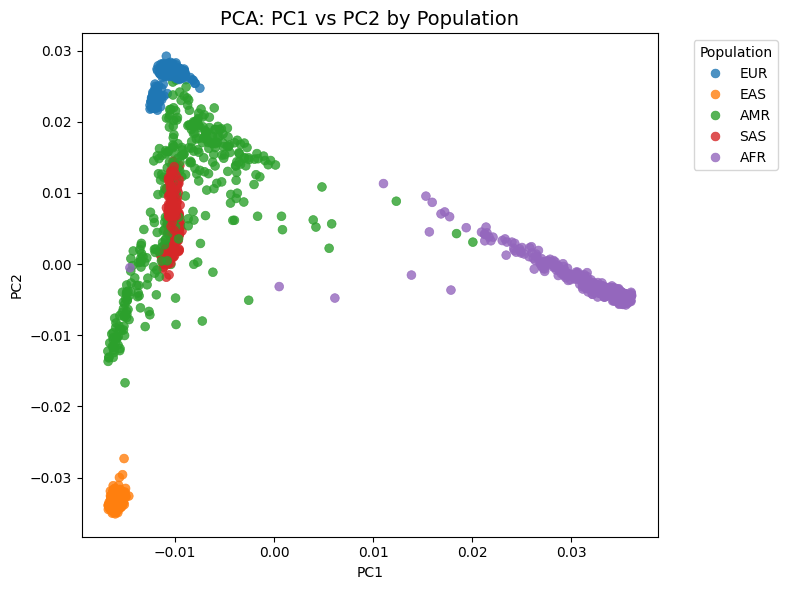

In [9]:
pc_x = 1
pc_y = 2

# assuming your dataframe is called df
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pcs_df,
    x=f"PC{pc_x}",
    y=f"PC{pc_y}",
    hue="population",
    s=40,           # point size
    alpha=0.8,      # transparency
    edgecolor=None  # cleaner look
)

plt.title(f"PCA: PC{pc_x} vs PC{pc_y} by Population", fontsize=14)
plt.xlabel(f"PC{pc_x}")
plt.ylabel(f"PC{pc_y}")
plt.legend(title="Population", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()